In [1]:
!gpustat

master-nvidia-tesla-v100-hanoi  Thu Jan  7 01:26:39 2021  440.95.01
[0] Tesla V100-SXM2-32GB | 40'C,   3 % |  2917 / 32510 MB |


In [2]:
%load_ext autoreload
%autoreload 2
import sys
import time
sys.path.append('/root/code/TensorFlowASR')

In [4]:
import IPython
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nlpaug.augmenter.audio as naa
from augmentation import AudioTFRecordDataset
from tensorflow_asr.featurizers.speech_featurizers import NumpySpeechFeaturizer, TFSpeechFeaturizer 

In [5]:
sampling_rate = 16000
frame_length = 25 * 16000 // 1000
frame_step = 10 * 16000 // 1000
num_feature_bins = 80
nfft = 2 ** (frame_length - 1).bit_length()

def get_audio_noise_pair(dataset_iter):
    audio, noise = next(dataset_iter)
    return audio.numpy().squeeze(), noise.numpy().squeeze()

In [6]:
dataset = AudioTFRecordDataset(tfrecords_dir="/root/datasets/libri_asr/all-tfrecords",
                               noise_tfrecords_dir="/root/datasets/libri_asr/all-tfrecords",
                               shuffle=False).create()
dataset_iter = iter(dataset)

In [7]:
audio, noise = get_audio_noise_pair(dataset_iter)
audio, noise = get_audio_noise_pair(dataset_iter)

In [8]:
signal = audio[: 3 * sampling_rate]
IPython.display.Audio(data=signal, rate=sampling_rate)

## Waveform

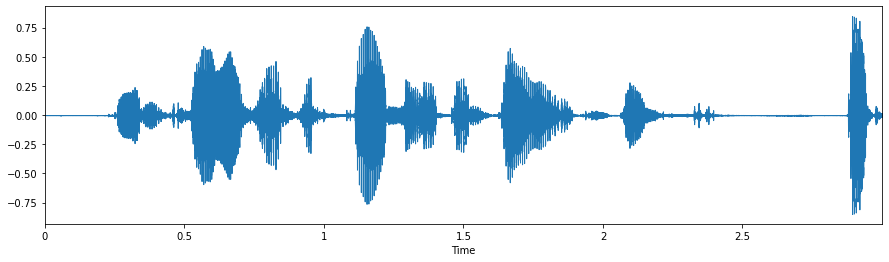

In [9]:
plt.figure(figsize=(15, 4))
librosa.display.waveplot(signal, sr=sampling_rate, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)

## Normalize signal

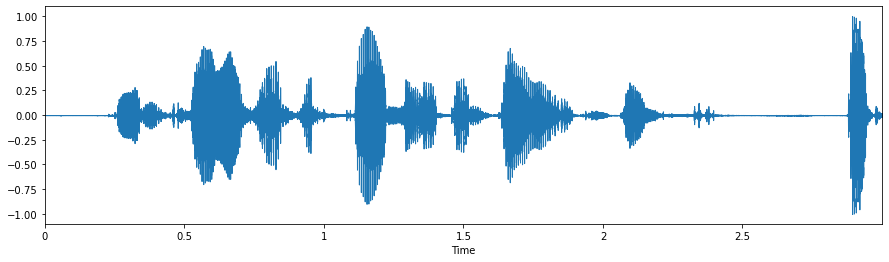

In [10]:
normalized_signal = signal / np.max(np.abs(signal) + 1e-6)
plt.figure(figsize=(15,4))
librosa.display.waveplot(normalized_signal, sr=sampling_rate, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)

In [11]:
IPython.display.Audio(data=normalized_signal, rate=sampling_rate)

## Pre-emphasis

A pre-emphasis filter is useful in several ways:

1. balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, 
2. avoid numerical problems during the Fourier transform operation and 
3. may also improve the Signal-to-Noise Ratio (SNR).

The pre-emphasis filter can be applied to a signal x using the first order filter in the following equation:

$y(t)=x(t)−αx(t−1)$

The typical values for the filter coefficient are $0.95$ or $0.97$

Pre-emphasis has a modest effect in modern systems, mainly because **most of the motivations for the pre-emphasis filter can be achieved using mean normalization** (discussed later in this post) except for avoiding the Fourier transform **numerical issues which should not be a problem in modern FFT implementations.**[1]

The signal after pre-emphasis has the following form in the time domain:

[1] https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

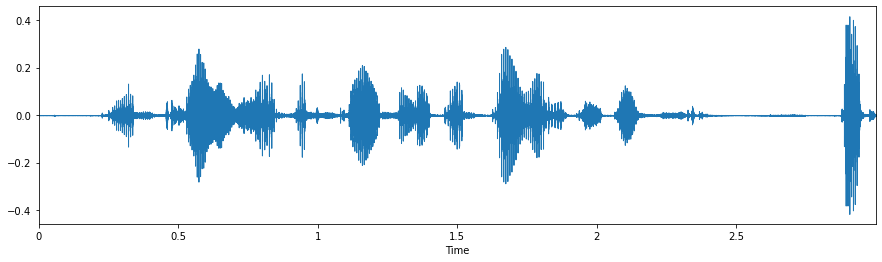

In [12]:
pre_emphasis = 0.95
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
plt.figure(figsize=(15,4))
librosa.display.waveplot(emphasized_signal, sr=sampling_rate, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000)

In [13]:
IPython.display.Audio(data=emphasized_signal, rate=16000)

## Spectrogram

This is motivated by the human cochlea (an organ in the ear) which vibrates at different spots depending on the frequency of the incoming sounds. **Depending on the location in the cochlea that vibrates (which wobbles small hairs), different nerves fire informing the brain that certain frequencies are present**. Our periodogram estimate performs a similar job for us, identifying which frequencies are present in the frame. In particular, $spectrogram(t, \omega) = \vert STFT(t, \omega)\vert^2$ is the squared of amplitude at time $t$ and frequency $\omega$ [1]

[1] http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

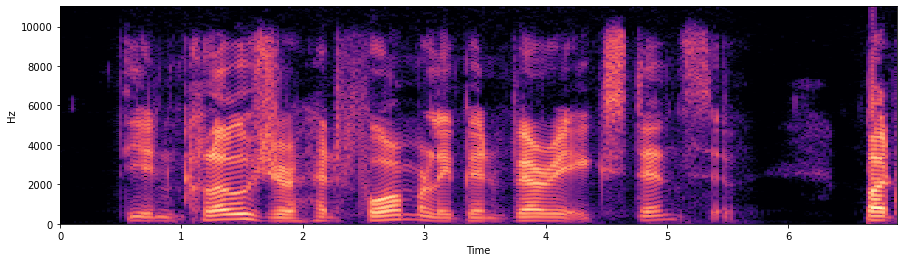

In [23]:
signal_stft = np.square(np.abs(librosa.stft(emphasized_signal, n_fft=nfft, hop_length=frame_step, win_length=frame_length, center=False, window="hann")))
spec = librosa.power_to_db(signal_stft, ref=1.0, amin=1e-10, top_db=80.0)
plt.figure(figsize=(15,4))
librosa.display.specshow(spec, x_axis='time', y_axis='linear')

* If we don't (log) rescale spectrogram

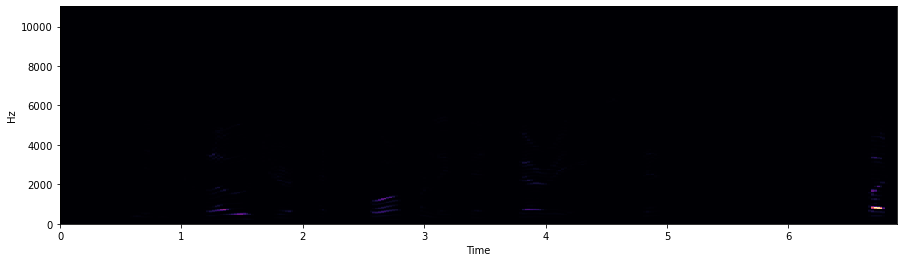

In [19]:
plt.figure(figsize=(15,4))
librosa.display.specshow(signal_stft, x_axis='time', y_axis='linear')

In [24]:
print(signal_stft.shape)
print(spec.shape)

(257, 297)
(257, 297)


* Use different number of frequency bins

In [30]:
num_frames = (len(emphasized_signal) - frame_length) / frame_step
print(num_frames)

297.5


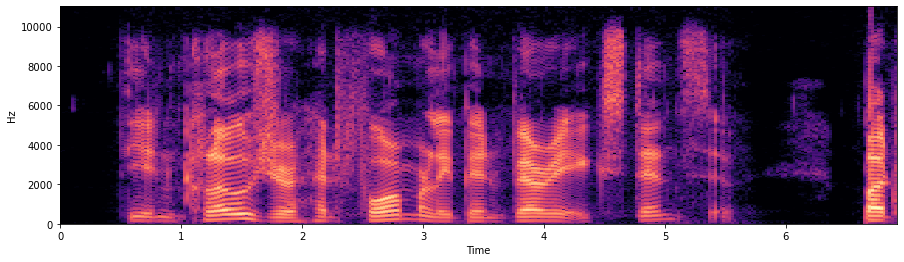

In [25]:
signal_stft_1 = np.square(np.abs(librosa.stft(emphasized_signal, n_fft=frame_length, hop_length=frame_step, win_length=frame_length, center=False, window="hann")))
spec_1 = librosa.power_to_db(signal_stft_1, ref=1.0, amin=1e-10, top_db=80.0)
plt.figure(figsize=(15,4))
librosa.display.specshow(spec_1, x_axis='time', y_axis='linear')

In [26]:
print(signal_stft_1.shape)
print(spec_1.shape)

(201, 298)
(201, 298)


## Log Mel Spectrogram

The periodogram spectral estimate still contains a lot of information not required for Automatic Speech Recognition (ASR). In particular the cochlea can not discern the difference between two closely spaced frequencies. This effect becomes more pronounced as the frequencies increase. In other words, **humans are much better at discerning small changes in pitch at low frequencies than they are at high frequencies. For this reason we take clumps of periodogram bins and sum them up to get an idea of how much energy exists in various frequency regions.** This is performed by our Mel filterbank: the first filter is very narrow and gives an indication of how much energy exists near 0 Hertz. As the frequencies get higher our filters get wider as we become less concerned about variations. We are only interested in roughly how much energy occurs at each spot. The Mel scale tells us exactly how to space our filterbanks and how wide to make them. In particular, the formula for converting from frequency to Mel scale is:[1]

$M(f) = 1125\ln(1 + f/700)$

To go from Mels back to frequency:

$M^{-1}(m) = 700(\exp(m/1125) - 1)$

Once we have the filterbank energies, we take the logarithm of them. This is also motivated by human hearing: **we don't hear loudness on a linear scale. Generally to double the percieved volume of a sound we need to put 8 times as much energy into it**. This means that large variations in energy may not sound all that different if the sound is loud to begin with. This compression operation makes our features match more closely what humans actually hear. Why the logarithm and not a cube root? The logarithm allows us to use cepstral mean subtraction, which is a channel normalisation technique. 

With librosa, we can simply compute a linear transformation matrix to project FFT bins onto Mel-frequency bins.

[1] http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

In [31]:
?librosa.power_to_db

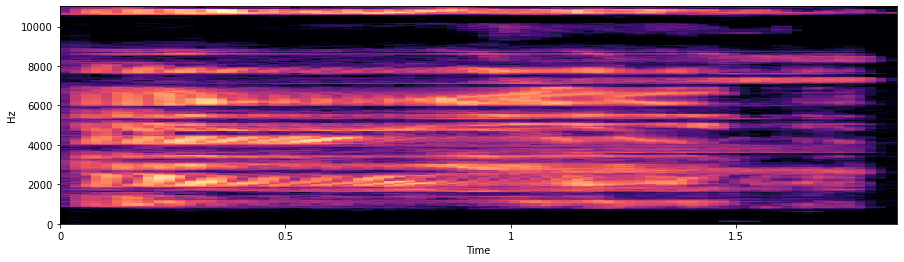

In [32]:
# produce a linear transformation matrix to project FFT bins onto Mel-frequency bins
# the matrix has shape=(n_mels, 1 + nfft/2)
mel = librosa.filters.mel(sampling_rate, nfft, n_mels=num_feature_bins, fmin=0.0, fmax=int(sampling_rate / 2))
# sum up power in each Mel-frequency bins
mel_spec = np.dot(signal_stft.T, mel.T)
# take log of the amplitude
mel_spec = librosa.power_to_db(mel_spec, ref=1.0, amin=1e-10, top_db=80.0)
# visualize
plt.figure(figsize=(15,4))
librosa.display.specshow(mel_spec, x_axis='time', y_axis='linear')

In [34]:
print(signal_stft.shape)
print(mel.shape)
print(mel_spec.shape)

(257, 297)
(80, 257)
(297, 80)


To balance the spectrum and improve the Signal-to-Noise (SNR), we can simply subtract the mean of each coefficient from all frames.



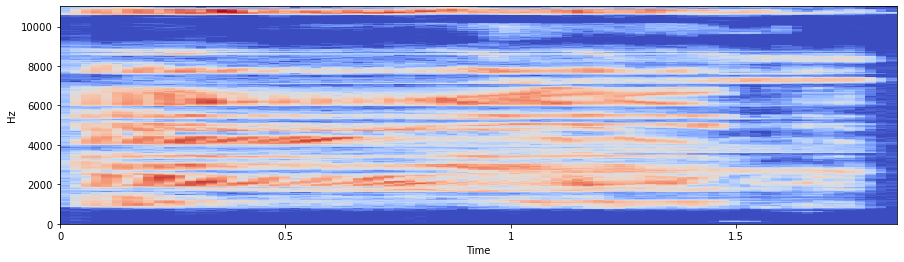

In [35]:
mel_spec_mean = np.mean(mel_spec)
mel_spec_std = np.std(mel_spec) + 1e-9
mel_spec_norm = (mel_spec - mel_spec_mean) / mel_spec_std

plt.figure(figsize=(15,4))
librosa.display.specshow(mel_spec_norm, x_axis='time', y_axis='linear')

## Mel-Frequency Cepstral Coefficients (MFCC)

The final step is to compute the Discrete Cosine Transform of the log filterbank energies. There are 2 main reasons this is performed.[1]

1. **Our filterbanks are all overlapping, the filterbank energies are quite correlated with each other. The DCT decorrelates the energies which means diagonal covariance matrices can be used to model the features in e.g. a HMM classifier.**


2. The higher DCT coefficients represent fast changes in the filterbank energies and it turns out that these fast changes actually degrade ASR performance, so we get a small improvement by dropping them. Therefore, only 12 of the 26 DCT coefficients are kept.

Regarding the first reason, one might question if MFCCs are still the right choice for Deep Learning models given that deep neural networks are less susceptible to highly correlated input and therefore **the Discrete Cosine Transform (DCT) is no longer a necessary step**. It is beneficial to note that Discrete Cosine Transform (DCT) is a linear transformation, and therefore undesirable as it discards some information in speech signals which are highly non-linear.

It is interesting to note that **all steps needed to compute filter banks were motivated by the nature of the speech signal andthe human perception of such signals.** On the contrary, the **extra steps needed to compute MFCCs were motivated by thelimitation of some machine learning algorithms**.[2] The Discrete Cosine Transform (DCT) was needed to decorrelate filter bankcoefficients, a process also referred to as whitening. In particular, **MFCCs were very popular when Gaussian Mixture Models -Hidden Markov Models (GMMs-HMMs) were very popular** and together, MFCCs and GMMs-HMMs co-evolved to be the standard way of doing Automatic Speech Recognition (ASR) 

[1] http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

[2] https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [ ]:
# produce a linear transformation matrix to project FFT bins onto Mel-frequency bins
# the matrix has shape=(n_mels, 1 + nfft/2)
mel = librosa.filters.mel(sampling_rate, nfft, n_mels=num_feature_bins, fmin=0.0, fmax=int(sampling_rate / 2))
# sum up power in each Mel-frequency bins
mel_spec = np.dot(signal_stft.T, mel.T)
# take log of the amplitude
mel_spec = librosa.power_to_db(mel_spec, ref=1.0, amin=1e-10, top_db=80.0)
# compute the DCT of the log filterbank energies
mfcc = librosa.feature.mfcc(sr=sampling_rate,
                            S= mel_spec,
                            n_mfcc=num_feature_bins)
# visualize
plt.figure(figsize=(15,4))
librosa.display.specshow(mfcc, x_axis='time', y_axis='linear')

## Computational Time Benchmarking

In [ ]:
N = 100
audios = [None] * N
noises = [None] * N

for i in range(N):
    audios[i], noises[i] = get_audio_noise_pair(dataset_iter)

In [ ]:
speech_config = {
    "sample_rate": 16000,
    "frame_ms": 25,
    "stride_ms": 10,
    "num_feature_bins": 80,
    "feature_type": "log_mel_spectrogram",
    "preemphasis": 0.97,
    "delta": False,
    "delta_delta": False,
    "pitch": False,
    "normalize_signal": True,
    "normalize_feature": True,
    "normalize_per_feature": False    
}
np_featurizer = NumpySpeechFeaturizer(speech_config)
tf_featurizer = TFSpeechFeaturizer(speech_config)

### 1. Using Numpy/Librosa

Takes on average 62.5ms

In [ ]:
t1 = []
time0 = time.time()
for i in range(N):
    start = time.time()
    features = np_featurizer.extract(audios[i])
    duration = time.time() - start
    t1.append(duration * 1000)
    print(f"{i}-th audio took {duration * 1000}ms")
    
print("{} batches took {}ms".format(N, (time.time() - time0) * 1000))
print("Each pair took on average {}ms".format(np.array(t1).mean()))

### 2. Using TF Data

Takes on average 28.8ms

In [ ]:
t2 = []
time0 = time.time()
for i in range(N):
    start = time.time()
    features = tf_featurizer.extract(audios[i])
    duration = time.time() - start
    t2.append(duration * 1000)
    print(f"{i}-th audio took {duration * 1000}ms")
    
print("{} batches took {}ms".format(N, (time.time() - time0) * 1000))
print("Each pair took on average {}ms".format(np.array(t2).mean()))